# TITULO FODA

titulo foda do trabalho, ilum escola de ciencias, nossos nomes (te amo)

# Introdução

Algo teórico sobre colisões e pq é legal de prever os jets etc

explicar o objetivo do trabalho e o dataset.

## Importações

Vamos começar importando as bibliotecas necessárias para os códigos do projeto. Utilizamos as bibliotecas `pandas` e `numpy` para a manipulação e análise do dataset, `matplotlib` para visualização de gráficos, e `optuna` para otimização de hiperparâmetros.

Do scikit-learn, usamos módulos para divisão dos dados, normalização, criação de pipelines, treinamento de modelos de classificação e avaliação de desempenho.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

## Tratamento de dados

Como visto na introdução, o dataset `MultiJetRun2010B`oriundo da CMS/CERN será utilizado. Contido nele há eventos de colisões de prótons com várias medições físicas detectadas, como:

`MR`: Escala de massa do evento

`Rsq`: Variável relacionada à energia e momento do evento

`E1`, `E2`: Energias dos dois jatos principais

`Px1`, `Py1`, `Pz1`, `Px2`, `Py2`, `Pz2`: Componentes do momento linear em cada direção espacial dos dois jatos

`HT`: Soma escalar dos momentos transversos de todos os jatos

`MET`: Energia transversal ausente – Missing Transverse Energy

A coluna `nJets` representa o número de jatos de hádrons detectados em cada colisão e será utilizado como target no processo de classificação.


In [20]:
pd.set_option("display.max_rows", 6)

df = pd.read_csv("Dataset\MultiJetRun2010B.csv")
df

<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\joao25017\AppData\Local\Temp\ipykernel_12104\2296493663.py:3: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("Dataset\MultiJetRun2010B.csv")


,Run,Lumi,Event,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets,nBJets
0,148029,388,302318745,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2,0
1,148029,388,302323641,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2,0
2,148029,388,302336217,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,149181,1804,1703621104,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4,0
21724,149181,1804,1703642752,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2,0
21725,149181,1804,1703634776,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4,0


As colunas `Run`, `Lumi` e `Event` são apenas para identificação de eventos, então podemos retirá-las. O mesmo vale para a `nBJets` pois o mesmo não é relevante para o nosso trabalho.

Dessa forma, iremos definir apenas os dados que nos interessa como atributos, além de definir a `nJets` como target.

In [21]:
atributos = ["MR", "Rsq", "E1", "Px1", "Py1", "Pz1", "E2", "Px2", "Py2", "Pz2", "HT", "MET"]
target = ["nJets"]

df = df.reindex(atributos + target, axis=1)
df = df.dropna()
df

,MR,Rsq,E1,Px1,Py1,Pz1,E2,Px2,Py2,Pz2,HT,MET,nJets
0,215.553,0.031977,136.7100,-109.8930,-54.03420,-58.9032,142.1790,70.0254,41.1225,-116.5130,203.666,18.31100,2
1,155.437,0.042157,83.3865,81.1500,6.88361,-12.9688,73.9025,-72.2472,11.8835,3.0899,154.659,14.77470,2
2,400.563,0.026938,253.1840,139.9020,102.64000,-101.9350,535.5510,-110.3790,-89.0929,-516.1790,343.280,25.22110,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21723,484.392,0.000920,197.1530,-61.5507,21.76930,110.9250,483.9510,47.5292,-37.9600,-470.8470,261.615,3.71479,4
21724,215.713,0.055836,647.4060,-78.9546,-88.75690,636.3600,383.0890,80.5702,49.3765,371.1240,213.289,20.95540,2
21725,547.384,0.001232,242.4140,191.2180,-118.75800,-37.2528,414.6670,-175.4890,83.3315,355.2330,444.869,1.84347,4


Antes de continuarmos, é necessário observar algo sobre o target.

In [22]:
contagem = df["nJets"].value_counts()
print(contagem)

porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1325
5      169
6       23
7        3
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.098684
5     0.777870
6     0.105864
7     0.013808
Name: proportion, dtype: float64


Note que as classes de contagem de jets "4" pra cima possuem uma frequência muito baixa, sendo praticamente irrelevantes para o treinamento futuro. Portanto, podemos agrupá-lás para amenizar isso.

In [23]:
df["nJets"] = df["nJets"].apply(lambda x: x if x <= 3 else 4)

contagem = df["nJets"].value_counts()
print(contagem)
porcentagem = df["nJets"].value_counts(normalize=True) * 100
print(porcentagem)

nJets
2    14002
3     6204
4     1520
Name: count, dtype: int64
nJets
2    64.448127
3    28.555648
4     6.996226
Name: proportion, dtype: float64


Dessa forma, a classe "4" para os `nJets` passa a indicar "4 ou mais" jets detectados.

Perceba que ainda há um desbalanceamento na frequência das classes. Isso pode afetar de maneira negativa os modelos, pois ele tende a aprender mais sobre a classe majoritária e ignorar as minoritárias. 

Para corrigir isso, utilizaremos de técnicas de `atribuição de pesos de classe`, dando mais importância às classes minoritárias durante o treinamento. Esse conceito será melhor explicado mais à frente do trabalho.

### Split dos dados

A forma como dividimos os dados entre treino e teste também deve ser cuidadosamente definida, garantindo que todos os modelos sejam avaliados de maneira justa. A semente aleatória atua como um hiperparâmetro que deve ser fixado antes do treinamento, assegurando que a divisão dos dados e quaisquer processos aleatórios sejam consistentes entre diferentes execuções. Embora não influencie diretamente a acurácia do modelo, ela é fundamental para reprodutibilidade dos resultados. 

Para este estudo, iremos reservar 20% dos dados para teste, enquanto o restante será alocado para treino. Além disso, manteremos a proporção das classes de `nJets` equilibrada entre os conjuntos de treino e teste utilizando o argumento `stratify`.

In [24]:
semente_aleatoria = 2307 #amo esse numero totalmente aleatorio
tamanho_teste = 0.2

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=tamanho_teste, random_state=semente_aleatoria, stratify=df["nJets"]
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

X_treino = df_treino[atributos].values
y_treino = df_treino[target].values.ravel()

X_teste = df_teste[atributos].values
y_teste = df_teste[target].values.ravel()


Usaremos o `StandardScaler` para normalizar os atributos, transformando-os para que tenham média zero e desvio padrão 1. Isso evita que variáveis com escalas maiores dominem o modelo e garante que algoritmos sensíveis à magnitude dos dados funcionem de maneira eficiente.

In [25]:
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

# Treinamento dos modelos

## Árvore de Decisões

A árvore de decisão é um algoritmo de classificação  que organiza os dados em uma estrutura hierárquica de divisões, onde cada nó separa os exemplos em subconjuntos menores com base nos atributos disponíveis. Esse processo continua até atingir as folhas, que representam a classe final prevista para cada exemplo.

O funcionamento da árvore consiste em analisar todos os dados disponíveis e, em cada nó, realizar a divisão que melhor separa as classes de acordo com um critério de impureza. Cada divisão cria novos nós, e o processo se repete até que não haja mais subdivisões necessárias, determinando a classe predita em cada folha.

Em nosso trabalho, iremos treinar um modelo de Árvore de Decisão para prever `nJets` a partir de atributos físicos das colisões de prótons. Para isso, utilizaremos um `pipeline` que inclui padronização dos dados, e faremos otimização de hiperparâmetros com o Optuna para obter o melhor desempenho do modelo, levando em consideração também o desbalanceamento das classes por meio de pesos.

------------------------------------------------------------------------------------------------------------------

Quando trabalhamos com classes desbalanceadas, o modelo pode ficar tendencioso para a classe majoritária. Isso acontece porque, sem ajustes, o algoritmo não penaliza suficientemente os erros das classes minoritárias, que são menos representadas nos dados.

O parâmetro `class_weight="balanced"` corrige isso atribuindo pesos inversamente proporcionais à frequência das classes. Ou seja, quanto menos frequente a classe, maior será o seu peso na função de aprendizado, fazendo com que classes minoritárias sejam mais consideradas pelo modelo.

------------------------------------------------------------------------------------------------------------------

Fora isso, a abordagem do `pipeline` facilita a execução de várias etapas de pré-processamento e modelagem em sequência, permitindo que padronizemos o fluxo de trabalho e apliquemos transformações nos dados de forma consistente e automatizada, sem repetições desnecessárias. Inicialmente, aplicaremos o `StandardScaler()` para padronizar os dados, garantindo que todas as variáveis estejam na mesma escala antes de ajustar o `DecisionTreeClassifier`, o que ajuda o modelo a aprender de forma mais eficiente.

In [26]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=semente_aleatoria, class_weight="balanced")
)

Para avaliar o desempenho do modelo de forma confiável, utilizamos o `StratifiedKFold` nos dados de X_treino e y_treino. Essa técnica de validação cruzada divide o conjunto de treino em vários folds, mantendo em cada um deles a mesma proporção de classes presente no dataset original. Dessa forma, evitamos que alguma classe minoritária fique sub-representada em algum fold, o que poderia distorcer a avaliação do modelo.

Para medir o desempenho em cada fold, utilizamos a métrica de `F1-weighted`, que combina precisão (precision) e revocação (recall) em uma única medida, ponderando o impacto de cada classe de acordo com sua frequência no conjunto de dados. Essa métrica é especialmente útil em problemas com classes desbalanceadas, pois avalia o desempenho global do modelo levando em consideração tanto as classes majoritárias quanto as minoritárias de forma proporcional.

In [27]:
num_folds = 10
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)

metricas = cross_val_score(
    modelo_ad_pipeline,
    X_treino,
    y_treino,
    cv=skf,
    scoring="f1_weighted"
)

score_medio = metricas.mean()
print("Valor do F1_weighted em cada fold:", metricas)
print("Valor médio", score_medio)

Valor do F1_weighted em cada fold: [0.71911223 0.71946067 0.69216612 0.7070916  0.70080966 0.68764985
 0.7026415  0.71007314 0.7112263  0.70233485]
Valor médio 0.7052565920755243


### Otimização utilizando Optuna

O `Optuna` é uma biblioteca de otimização de hiperparâmetros que permite encontrar automaticamente as melhores combinações para algoritmos de machine learning. O processo começa com a definição de uma função objetivo, que especifica os hiperparâmetros a serem testados e o modelo a ser treinado. Em seguida, o Optuna explora de forma eficiente o espaço de hiperparâmetros, avaliando diferentes configurações com base em uma métrica de desempenho escolhida.

Definiremos uma função `cria_instancia_modelo_ad(trial)`, que irá utilizar do `Optuna` para sugerir valores da Árvore de Decisão Classificadora.

In [28]:
def cria_instancia_modelo_ad(trial):
    
    parametros_ad = {
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
        "max_depth": trial.suggest_int("max_depth", 2, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
        "class_weight": "balanced",  
        "random_state": semente_aleatoria
    }

    modelo = DecisionTreeClassifier(**parametros_ad)
    return modelo


Criaremos agora a função `objetivo_ad`, responsável por avaliar o desempenho do modelo com diferentes combinações de hiperparâmetros sugeridas pelo Optuna no trial, utilizando validação cruzada e a métrica F1-weighted.

In [29]:
def objetivo_ad(trial, X, y, num_folds):
    
    modelo = cria_instancia_modelo_ad(trial)
    
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=semente_aleatoria)
    
    metricas = cross_val_score(
        modelo,
        X,
        y,
        cv=skf,
        scoring="f1_weighted"
    )
    
    return metricas.mean()

Criaremos agora o objeto de estudo do `Optuna`, podendo armazenar o resultado da otimização e reutilizá-los depois sem precisar realizar o processo novamente. Além disso, o estudo será utilizado para defirmos alguns parâmetros de otimização.

In [30]:
nome_do_estudo = "decision_tree_nJets"
pasta = "Estudos do Optuna"
caminho_db = f"{pasta}/{nome_do_estudo}"


study_ad = optuna.create_study(
    direction="maximize",
    study_name=nome_do_estudo,
    storage=f"sqlite:///{caminho_db}.db", 
    load_if_exists=True
)

[I 2025-10-19 10:53:27,743] Using an existing study with name 'decision_tree_nJets' instead of creating a new one.


A função `objetivo_parcial_ad` é uma adaptação da função original feita para que o `Optuna` consiga executar o processo de otimização de forma mais simples. Nela, os dados de treinamento (X_treino e y_treino) e o número de folds (num_folds) já ficam definidos, enquanto o Optuna altera apenas o parâmetro trial a cada iteração, permitindo que diferentes combinações de hiperparâmetros sejam avaliadas automaticamente.

In [31]:
def objetivo_parcial_ad(trial):
    return objetivo_ad(trial, X_treino, y_treino, num_folds)

Com todas as funções definidas, o próximo passo é executar o `Optuna` para realizar a otimização dos hiperparâmetros. Definimos 100 tentativas (trials), nas quais o `Optuna` irá testar diferentes combinações de parâmetros do modelo, avaliando o desempenho em cada uma delas para, ao final, selecionar automaticamente aquela que apresentar os melhores resultados.

In [32]:
num_tentativas = 100
trials_ja_feitos = len(study_ad.trials)
if trials_ja_feitos < num_tentativas:
    study_ad.optimize(objetivo_parcial_ad, n_trials=num_tentativas - trials_ja_feitos)

[I 2025-10-19 10:53:40,234] Trial 99 finished with value: 0.7123304794906578 and parameters: {'criterion': 'entropy', 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 14 with value: 0.7132023542986157.


In [33]:
print("Melhores hiperparâmetros encontrados:")
print(study_ad.best_params)
print(f"Número do melhor trial: {study_ad.best_trial.number}")
print(f"Melhor valor de F1: {study_ad.best_value}")

Melhores hiperparâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None}
Número do melhor trial: 14
Melhor valor de F1: 0.7132023542986157


Criaremos agora um `pipeline` que combina o `StandardScaler` para normalizar os dados com a instância do modelo de árvore de decisão configurada com os melhores hiperparâmetros encontrados pelo `Optuna`. Em seguida, treinaremos esse pipeline nos dados de treino e avaliaremos seu desempenho no conjunto de teste, utilizando a métrica `F1_weighted` para medir a performance do modelo levando em conta o desbalanceamento das classes.

In [34]:
modelo_ad_pipeline = make_pipeline(
    StandardScaler(),  
    DecisionTreeClassifier(random_state=semente_aleatoria, **study_ad.best_trial.params, class_weight="balanced")
)

modelo_ad_pipeline.fit(X_treino, y_treino)

y_pred = modelo_ad_pipeline.predict(X_teste)

f1_ad_final = f1_score(y_teste, y_pred, average="weighted")
print("F1-score ponderado final:", f1_ad_final)

F1-score ponderado final: 0.7135445154439206


### Explicação do modelo

Para extrair informações do modelo e explicá-lo utilizaremos do `Permutation Importance`. 

O Permutation Importance é uma técnica usada para medir a importância de cada variável em um modelo preditivo. A ideia básica é avaliar quanto a performance do modelo piora quando os valores de uma variável específica são embaralhados (permutados), quebrando a relação dessa variável com a saída. Se a métrica de desempenho do modelo cair significativamente após a permutação, isso indica que a variável é importante para a predição. Por outro lado, se a métrica permanecer quase igual, a variável provavelmente tem pouca influência no modelo. Esse método é particularmente útil porque pode ser aplicado a qualquer modelo, mesmo aqueles que não fornecem diretamente medidas internas de importância dos atributos.

Importância das features (Permutation Importance):
HT: 0.24110543768890938
MR: 0.053289481366053985
Px2: 0.05013916080276915
Py2: 0.04774403659289318
Px1: 0.039153265239875355
Py1: 0.03700794413253662
E1: 0.0339859681340466
Pz1: 0.029002889793221652
E2: 0.01739433614489277
Rsq: 0.01447106416375444
Pz2: 0.006151836758721359
MET: 0.004415243592899313


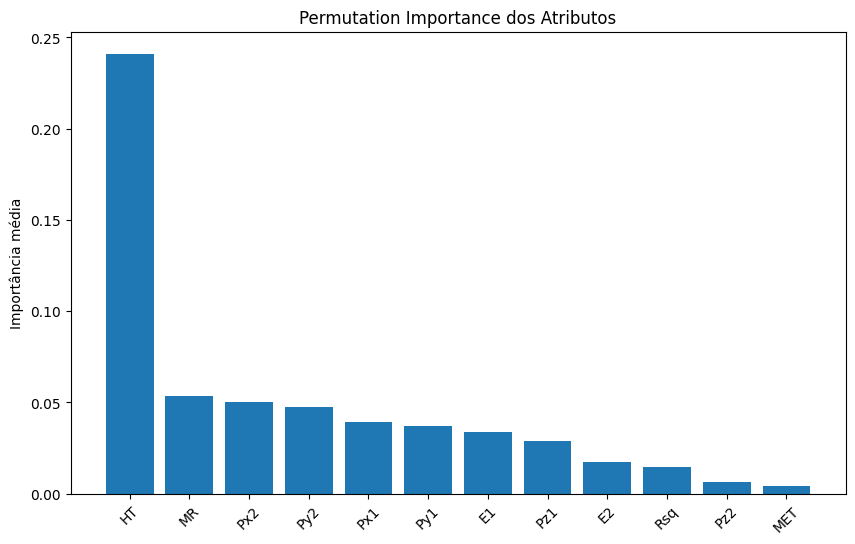

In [35]:
resultado_perm = permutation_importance(
    modelo_ad_pipeline,
    X_teste,
    y_teste,
    n_repeats=30,
    random_state=semente_aleatoria,
    scoring="f1_weighted"
)

importancia_atributos = resultado_perm.importances_mean
indices = np.argsort(importancia_atributos)[::-1]  

print("Importância das features (Permutation Importance):")
for i in indices:
    print(f"{atributos[i]}: {importancia_atributos[i]}")

plt.figure(figsize=(10,6))
plt.bar([atributos[i] for i in indices], importancia_atributos[indices])
plt.xticks(rotation=45)
plt.ylabel("Importância média")
plt.title("Permutation Importance dos Atributos")
plt.show()

## Comparação do desempenho

Usar alguma métrica (provavelmente RMSE), fazer validação cruzada

da pra incluir alguns graficos de dados reais/previstos

## Discussão dos resultados

discussao de tudo

## Conclusão

Não precisa ser longo, 2 paragrafos ja ta bom

## Referências

Ir citando conforme necessario